In [ ]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/bigdataleeky/python/main/data/mobile_phone.csv')
df.head()

,create_date,price,text,phone_model,factory_price,maker,price_index
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96
1,2016-10-26 12 08 00 PM,380000.0,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05
2,2016-10-25 12 52 00 PM,300000.0,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...,galaxy s6 32gb,854000,samsung,103.05
3,2017-03-23 11 14 00 PM,290000.0,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...,lg g5 32gb,836000,lg,95.96
4,2016-04-11 7 35 00 PM,280000.0,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...,lg u 32gb,396000,lg,102.59


In [ ]:
from datetime import datetime
import time
def change_unixtime(str_date):
    timestamp =  time.mktime(datetime.strptime(str_date,'%Y-%m-%d').timetuple() )
    return timestamp

In [ ]:
df['create_date'][0][:10]

'2017-03-19'

In [ ]:
change_unixtime(df['create_date'][0][:10])

1489881600.0

In [ ]:
df['create_date_unixtime'] = df['create_date'].apply(lambda x :change_unixtime(x[:10]) )
df['create_date_unixtime'][:6]

0    1.489882e+09
1    1.477440e+09
2    1.477354e+09
3    1.490227e+09
4    1.460333e+09
5    1.490141e+09
Name: create_date_unixtime, dtype: float64

In [ ]:
# min-max scaling  - std
# X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
# X_scaled = X_std * (max - min) + min
# sklearn.preprocessing.MinMaxScaler

# (각 요소 - 평균) / (최대값 - 최소값)
df['create_unixtime_scale'] = (df['create_date_unixtime'] - df['create_date_unixtime'].min()) / \
        (df['create_date_unixtime'].max() - df['create_date_unixtime'].min())
df[['create_date','create_date_unixtime','create_unixtime_scale']].head()  

,create_date,create_date_unixtime,create_unixtime_scale
0,2017-03-19 4 35 00 PM,1.489882e+09,0.985612
1,2016-10-26 12 08 00 PM,1.477440e+09,0.640288
2,2016-10-25 12 52 00 PM,1.477354e+09,0.637890
3,2017-03-23 11 14 00 PM,1.490227e+09,0.995204
4,2016-04-11 7 35 00 PM,1.460333e+09,0.165468


In [ ]:
# phone model 을 분리
df['phone_model_st'] =  df['phone_model'].apply(lambda x : x.split(" ")[-1])
df['phone_model_detail'] = df['phone_model'].apply(lambda x : ' '.join( x.split(" ")[:-1]))
df[['phone_model_st','phone_model_detail']].head()

,phone_model_st,phone_model_detail
0,64gb,iphone 6
1,32gb,galaxy s6 edge
2,32gb,galaxy s6
3,32gb,lg g5
4,32gb,lg u


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


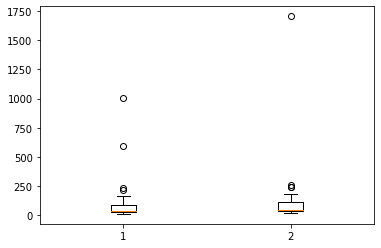

In [ ]:
# 모델별 거래
model_counts =  df['phone_model'].value_counts()
model_detail_counts =  df['phone_model_detail'].value_counts()

temp = [model_counts, model_detail_counts]
# 두 피처간의 기종별 거래 데이터
import matplotlib.pyplot as plt

plt.boxplot(temp)
plt.show()

In [ ]:
# 기종명+용량으로 
model_storage_factory_dic = {}

for index, row in  df.iterrows():
    model_concat =  (row['phone_model_detail'], row['phone_model_st'])
    if model_concat in model_storage_factory_dic:
        pass
    else:
        model_storage_factory_dic[model_concat] = row['factory_price']
str(model_storage_factory_dic)[:50]

"{('iphone 6', '64gb'): 924000, ('galaxy s6 edge', "

In [ ]:
# z-score.....  평균으로부터 표준편차의 몇배 만큼 떨어져 있는지를 보여주는 지수
# z = (x - mean) / std
# price z score : 어떤 데이터의 가격이 해당 기종의 평균에 비해 어느정도 높거나 낮은지 알수있게
df['zscore_price'] = df.groupby('phone_model_detail')['price'].transform(lambda x: (x - x.mean()) / x.std())

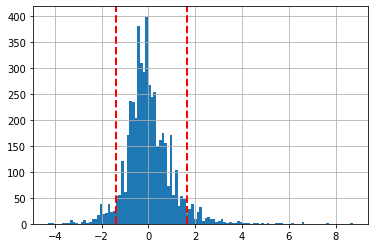

In [ ]:
ax = df['zscore_price'].hist(bins='auto')
lower= df['zscore_price'].quantile(0.05)
upper = df['zscore_price'].quantile(0.95)

ax.axvline(x = lower,color = 'r', linestyle='dashed', linewidth=2)
ax.axvline(x = upper,color = 'r', linestyle='dashed', linewidth=2)

plt.show()


In [ ]:
def makepricelevel(price, lower, upper):
    if price > upper:
        return 2
    elif price > lower:
        return 1
    else:
        return 0;

In [ ]:
df['lower_price'] =  df.groupby('phone_model_detail')['price'].transform(lambda x: x.quantile(0.05))
df['upper_price'] =  df.groupby('phone_model_detail')['price'].transform(lambda x: x.quantile(0.95))
df['price_level'] =  df.apply(lambda x : makepricelevel(x['price'],x['lower_price'],x['upper_price']), axis=1)
df[['price','lower_price','upper_price','price_level','text' ]].head()

,price,lower_price,upper_price,price_level,text
0,550000.0,180000.0,680000.0,1,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...
1,380000.0,180000.0,414000.0,1,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...
2,300000.0,150000.0,349000.0,1,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...
3,290000.0,100000.0,500000.0,1,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...
4,280000.0,18000.0,400000.0,1,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...


In [ ]:
import pickle
import re
with open('stopwords.pkl', 'rb') as f:
    swords =  pickle.load(f)    

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 448 kB 49.7 MB/s 


In [ ]:
from konlpy.tag import Okt
# ‘+’를 제외한 특수문자를 제거하고, 숫자형태의 문자를 제거합니다.
def text_cleaning(text):
    text = ''.join(c for c in text if c.isalnum() or c in '+, ')
    text = ''.join([i for i in text if not i.isdigit()])
    return text
    
def get_pos(x):
    tagger = Okt()
    poses = tagger.pos(x)
    return [pos[0] for pos in poses if pos[0] not in swords]

In [ ]:
# 위 함수들을 적용한 형태소 추출을 테스트합니다.
df['text'] = df['text'].apply(lambda x: text_cleaning(x))
result = get_pos(df['text'][0])
print(result)

['+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '리퍼', '기간', '만료', '되어서', '징', '하게', '되었습니다', '상태', '초', 'a', '급', '스', '없습니다', '+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '리퍼', '기간', '만료', '되어서', '징', '하게', '되었습니다', '상태', '초', 'a', '급', '스', '없습니다', '징', '애플', '라이트', '홈', '버튼', '링', '카메라', '링', '볼륨', '버튼', '슬립', '버튼', '검금', '심플', '튀지', '않게', '이쁘게', '했구요', '유심', '꽂고', '바로', '사용', '하시면', '됩니다', '사람', '이냐', '자주', '물어보고', '실제', '더욱', '이쁩니다', '밤', '영롱하게', '맥북', '뒷', '사과', '로고', '비춰지고', '요전', '넘어가기', '위해', '합니다', '가능합니다', '박스', '어머니', '버리시고', '이어폰', '충전기', '정품', '드립니다', '직거래', '우선', '순', '위로', '정', '싶으시면', '선', '입금', '택배', '발송', '해드리겠습니다', '믿으시면', '직거래', '하시길', '추천', '해요', '안전', '합니다', '서울시', '강남구', '역삼동', '차병원', '사거리', '근처', '가격']


In [ ]:
from collections import Counter

# get_pos 함수를 모든 텍스트 데이터에 적용하여 형태소 말뭉치를 추출합니다.
corpus = sum(df['text'].apply(lambda x: get_pos(x)).tolist(), [])
corpus

In [ ]:
# 추출된 형태소 말뭉치에서 가장 많이 등장한 형태소 2500개를 추출합니다.
counter = Counter(corpus)
common_words = [key for key, _ in counter.most_common(2500)]
common_words[:10]

['입니다', '직거래', 's', '합니다', '택배', '사용', '급', '상태', '팝니다', '가능합니다']

In [ ]:
df['price_level'].value_counts()

1    4388
0     334
2     229
Name: price_level, dtype: int64

In [ ]:
df[df['price_level']==0]

In [ ]:
#TF-IDF 
# TF : Term Frequency
# doc[0]
# i go to my home
# my home is very large

# doc[1]
# my home is very good

# 한개의 글자는 무시
# df : Document Frequency
# idf : df를 역수변환 idf = log((i+n) / (i+df)) + 1
# TF-IDF = TF X IDF



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# 빈출 형태소를 제외한 모든 형태소를 제거하는 함수를 정의합니다.
def get_common_pos(x):
    tagger = Okt()
    poses = tagger.pos(x)
    return [pos[0] for pos in poses if pos[0] in common_words]

# 1:3:1 비율로 랜덤 샘플링을 수행합니다.
negative_random = df[df['price_level']==0].sample(229, random_state=30)
neutral_random = df[df['price_level']==1].sample(229*3, random_state=30)
positive_random = df[df['price_level']==2].sample(229, random_state=30)

# 샘플링 완료된 데이터셋을 정의합니다.
df_sample = negative_random.append(neutral_random).append(positive_random)

# TF-IDF를 수행하여 피처를 변환합니다.
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_common_pos(x))
X = index_vectorizer.fit_transform(df_sample['text'].tolist())
tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)

# 감성 분류를 위한 학습 데이터셋을 정의합니다.
y = df_sample['price_level']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=30)
print(x_train.shape)
print(x_test.shape)

(916, 2437)
(229, 2437)


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# 비선형 SVM 분류 모델을 학습하고 평가합니다.
svm = SVC(kernel='rbf', C=10.0, random_state=0, gamma=0.10)
svm.fit(x_train, y_train)
y_pred_ksvc = svm.predict(x_test)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred_ksvc))

Accuracy: 0.74


In [ ]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix를 출력합니다.
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred_ksvc)
print(confmat)

[[ 19  19   2]
 [  8 124  13]
 [  1  17  26]]


In [ ]:
# Rendom Rorest를 이용해서 재 학습
# + 감성분류.... 뎃글을 긍정과 부정의 형태로 분류한 데이터를 사용하여 재 학습

In [42]:
df['text'].head()

0    아이폰플러스 블랙+애플라이트 기가 팝니다  아이폰플러스 블랙+애플라이트 기가 팝니다...
1    갤럭시s엣지 기가 팝니다 직거래  갤럭시s엣지 기가 품명 갤럭시s엣지제품 단품상태 ...
2    갤럭시s 풀박스로 팝니다 새상품급  실기스조차 없어요  직접거래 구매한지 개월만에 ...
3    sk  g 티탄 폰 단품판매합니다  직접거래 sk g 티탄 폰 단품판매합니다 올 월...
4     sony 엑스페리아 c ultra e gb  미사용 새제품 팝니다  소니 엑스페리...
Name: text, dtype: object

In [43]:
X = index_vectorizer.transform(df['text'].tolist())
X = tfidf_vectorizer.transform(X)
X

<4951x2437 sparse matrix of type '<class 'numpy.float64'>'
	with 197303 stored elements in Compressed Sparse Row format>

In [44]:
df['product_status'] = pd.Series( svm.predict(X))

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4951 entries, 0 to 4950
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   create_date            4951 non-null   object 
 1   price                  4951 non-null   float64
 2   text                   4951 non-null   object 
 3   phone_model            4951 non-null   object 
 4   factory_price          4951 non-null   int64  
 5   maker                  4951 non-null   object 
 6   price_index            4951 non-null   float64
 7   create_date_unixtime   4951 non-null   float64
 8   create_unixtime_scale  4951 non-null   float64
 9   phone_model_st         4951 non-null   object 
 10  phone_model_detail     4951 non-null   object 
 11  zscore_price           4951 non-null   float64
 12  lower_price            4951 non-null   float64
 13  upper_price            4951 non-null   float64
 14  price_level            4951 non-null   int64  
 15  prod

In [47]:
df.head(1)

,create_date,price,text,phone_model,factory_price,maker,price_index,create_date_unixtime,create_unixtime_scale,phone_model_st,phone_model_detail,zscore_price,lower_price,upper_price,price_level,product_status
0,2017-03-19 4 35 00 PM,550000.0,아이폰플러스 블랙+애플라이트 기가 팝니다 아이폰플러스 블랙+애플라이트 기가 팝니다...,iphone 6 64gb,924000,apple,95.96,1.489882e+09,0.985612,64gb,iphone 6,0.910563,180000.0,680000.0,1,1


In [48]:
df = df[['price','factory_price','maker','price_index','create_unixtime_scale','phone_model_st','phone_model_detail','product_status']]

In [49]:
df.head()

,price,factory_price,maker,price_index,create_unixtime_scale,phone_model_st,phone_model_detail,product_status
0,550000.0,924000,apple,95.96,0.985612,64gb,iphone 6,1
1,380000.0,979000,samsung,103.05,0.640288,32gb,galaxy s6 edge,1
2,300000.0,854000,samsung,103.05,0.637890,32gb,galaxy s6,1
3,290000.0,836000,lg,95.96,0.995204,32gb,lg g5,1
4,280000.0,396000,lg,102.59,0.165468,32gb,lg u,1


In [50]:
df['product_status'].value_counts()

1    3937
2     562
0     452
Name: product_status, dtype: int64

In [51]:
df = pd.get_dummies(df, columns=['maker','phone_model_st','phone_model_detail','product_status'])

In [52]:
df.head()

,price,factory_price,price_index,create_unixtime_scale,maker_apple,maker_huawei,maker_lg,maker_pantech,maker_samsung,maker_sky,...,phone_model_detail_nexus 5x,phone_model_detail_optimus g,phone_model_detail_vega iron2,phone_model_detail_vega secret up,phone_model_detail_wine smart jazz,phone_model_detail_xperia z3,phone_model_detail_y6,product_status_0,product_status_1,product_status_2
0,550000.0,924000,95.96,0.985612,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,380000.0,979000,103.05,0.640288,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,300000.0,854000,103.05,0.637890,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,290000.0,836000,95.96,0.995204,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,280000.0,396000,102.59,0.165468,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [54]:
Y = df['price']
X = df.iloc[:,1:]
X.head()

,factory_price,price_index,create_unixtime_scale,maker_apple,maker_huawei,maker_lg,maker_pantech,maker_samsung,maker_sky,maker_sony,...,phone_model_detail_nexus 5x,phone_model_detail_optimus g,phone_model_detail_vega iron2,phone_model_detail_vega secret up,phone_model_detail_wine smart jazz,phone_model_detail_xperia z3,phone_model_detail_y6,product_status_0,product_status_1,product_status_2
0,924000,95.96,0.985612,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,979000,103.05,0.640288,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,854000,103.05,0.637890,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,836000,95.96,0.995204,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,396000,102.59,0.165468,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [55]:
x_train,x_target,y_train,y_target = train_test_split(X , Y ,test_size=0.2, random_state=42)

In [58]:
from sklearn.ensemble import RandomForestRegressor
rfr =  RandomForestRegressor(n_estimators=1000,criterion='mse')
rfr.fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


RandomForestRegressor(criterion='mse', n_estimators=1000)

In [59]:
y_train_predic= rfr.predict(x_train)
y_target_predic= rfr.predict(x_target)

In [60]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [63]:
mean_squared_error(y_train, y_train_predic), mean_squared_error(y_target, y_target_predic)

(4817988877.709828, 9258684534.459486)

In [64]:
r2_score(y_train, y_train_predic), r2_score(y_target, y_target_predic)

(0.8974065070716164, 0.8049283990725238)

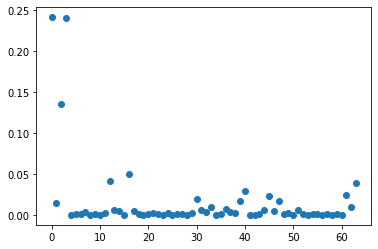

In [79]:
fearture_values =  rfr.feature_importances_
fearture_values
plt.plot(fearture_values, "o")